In [1]:
!pip install transformers
!pip install torch-summary
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 94.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.3/211.3 kB 29.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=1e4ba3072036ce354789e93bc55540d3a838f27bb244e8de922478587ab4e427
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm


import transformers
from transformers import BertTokenizer, BertModel
from transformers import AutoModel


import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchsummary
from torchsummary import summary

import wandb

import sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_auc_score, classification_report

#Data Preprocessing

In [ ]:
!wandb login #<Use Personal Wandb login key>

In [ ]:
wandb.login()

In [5]:
!mkdir /root/.kaggle

#Register into Kaggle competion to download data:
# https://www.kaggle.com/competitions/sentiment-analysis-on-movie-reviews

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"<ENTER KAGGLE USERNAME>","key":"<ENTER KAGGLE KEY>"}') # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

In [6]:
PATH = '/content/drive/MyDrive/sentiment_analyis/'    #Mount to drive and create this folder structure or specify other path

In [7]:
!pip install --upgrade --force-reinstall --no-deps kaggle

!kaggle competitions download -c sentiment-analysis-on-movie-reviews

!unzip -q sentiment-analysis-on-movie-reviews.zip
!unzip -q train.tsv.zip
!unzip -q test.tsv.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.15-py3-none-any.whl size=99605 sha256=96d15f3e99e868ac2972685cf9dd7660954ec5fd5c24bc5ad9fc29e5226cf2b2
  Stored in directory: /root/.cache/pip/wheels/46/0f/33/40c049c224ee941c2b3a7abb858fc34d93e827f9a833d40f09
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
 53% 1.00M/1.90M [00:00<00:00, 2.02MB/s]
100% 1.90M/1.90M [00:00<00:00, 3.27MB/s]


##Train Data

In [8]:
train_data = pd.read_csv('train.tsv', sep = '\t')
train_data.tail()

,PhraseId,SentenceId,Phrase,Sentiment
156055,156056,8544,Hearst 's,2
156056,156057,8544,forced avuncular chortles,1
156057,156058,8544,avuncular chortles,3
156058,156059,8544,avuncular,2
156059,156060,8544,chortles,2


In [9]:
lens = []
for i in train_data['Phrase']:
  lens.append(len(i))

max(lens)

283

<Axes: >

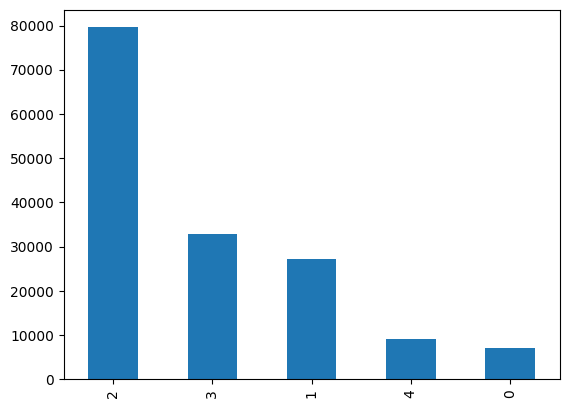

In [10]:
train_data['Sentiment'].value_counts().plot(kind = 'bar')

In [11]:
CLASSES = ['Negative', 'Somewhat Negative', 'Neutral', 'Somewhat Positive', 'Positive']

In [12]:
seq_len = 320
train_data_points = len(train_data)

print(train_data_points)


156060


In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [14]:
train_tokens = tokenizer(train_data['Phrase'].tolist(), max_length = seq_len, padding = 'max_length', truncation = True, add_special_tokens = True, return_tensors = 'np')

In [15]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
train_tokens['input_ids']

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]])

In [17]:
train_tokens['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [18]:
train_tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [19]:
with open('train_input_ids.npy','wb') as f:
  np.save(f, train_tokens['input_ids'])

with open('train_attention_mask.npy','wb') as f:
  np.save(f, train_tokens['attention_mask'])


In [20]:
train_labels = train_data['Sentiment'].values

In [21]:
train_labels.shape

(156060,)

In [22]:
one_hot_train_labels = np.zeros((len(train_labels), max(train_labels)+1))

In [23]:
one_hot_train_labels.shape

(156060, 5)

In [24]:
for i in range(len(train_labels)):

  one_hot_train_labels[i,train_labels[i]] = 1

In [25]:
one_hot_train_labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [26]:
with open('train_one_hot_labels.npy', 'wb') as f:
  np.save(f, one_hot_train_labels)


##TEST DATA

In [27]:
test_data = pd.read_csv('test.tsv', sep = '\t')
test_data.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [28]:
test_data_points = len(test_data)
print(test_data_points)

66292


In [29]:
test_tokens = tokenizer(test_data['Phrase'].tolist(), max_length = seq_len, padding = 'max_length', truncation = True, add_special_tokens = True, return_tensors = 'np')

In [30]:
test_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [31]:
test_tokens['input_ids']

array([[  101,  1760, 27946, ...,     0,     0,     0],
       [  101,  1760, 27946, ...,     0,     0,     0],
       [  101,  1760,   102, ...,     0,     0,     0],
       ...,
       [  101,   138,  1263, ...,     0,     0,     0],
       [  101,   138,  1263, ...,     0,     0,     0],
       [  101, 24017, 12671, ...,     0,     0,     0]])

In [32]:
test_tokens['token_type_ids']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
test_tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [34]:
with open('test_input_ids.npy','wb') as f:
  np.save(f, test_tokens['input_ids'])

with open('test_attention_mask.npy','wb') as f:
  np.save(f, test_tokens['attention_mask'])


#Data Loader

In [73]:
class CustomDataLoader(Dataset):
    def __init__(self, input_review_ids, attentions_masks, one_hot_labels = None, mode = 'train_val', phrase_id = None):


        self.mode = mode
        self.input_ids = input_review_ids
        self.attention_masks = attentions_masks


        if self.mode == 'train_val':
            self.labels = one_hot_labels

        else:
          self.phrase_id = phrase_id


    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):

        input = self.input_ids[idx,:]
        attention_mask = self.attention_masks[idx,:]
        ph_id = self.phrase_id[idx]

        if self.mode == 'train_val':
          labels = self.labels[idx,:]
          return {'input_ids':input, 'attention_masks':attention_mask} , labels

        else:
          return {'input_ids':input, 'attention_masks':attention_mask, 'PhraseId':ph_id}


In [65]:
train_dataset = CustomDataLoader(train_tokens['input_ids'], train_tokens['attention_mask'], one_hot_train_labels, mode = 'train_val')

In [66]:
train_dataset.__len__()

156060

In [67]:
len(train_dataset)

156060

In [75]:
test_dataset = CustomDataLoader(test_tokens['input_ids'], test_tokens['attention_mask'], mode = 'test', phrase_id = test_data['PhraseId'])

In [69]:
test_dataset.__len__()

66292

In [41]:
random_seed = 42
np.random.seed(random_seed)

In [42]:
train_val_split = 0.8
split = int(np.floor(train_val_split * len(train_data)))

indexes = [i for i in range(len(train_data))]
np.random.shuffle(indexes)

train_indices, val_indices = indexes[:split], indexes[split:]


In [43]:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [76]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE,  sampler = train_sampler, num_workers=4)
val_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = False, sampler = valid_sampler, num_workers = 4)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [45]:
len(train_loader)

7803

In [46]:
len(val_loader)

1951

In [ ]:
len(test_loader)

#MODEL

In [48]:
bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
print(bert)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [50]:
bert.config.hidden_size

768

In [51]:
class BertClassifier(torch.nn.Module):

    def __init__(self):
        super(BertClassifier, self).__init__()

        self.bert = bert
        self.layer1 = torch.nn.Linear(768, 1024)
        self.classifier = torch.nn.Linear(1024, 5)
        self.relu = torch.nn.ReLU()
        self.softmax = torch.nn.Softmax(dim = -1)

    def forward(self, input_ids, attention_masks):

        last_hidden_state, pooled_output = self.bert(input_ids, attention_masks)

        x = self.layer1(pooled_output)
        x = self.relu(x)
        x = self.classifier(x)

        return x


#TRAINING

In [52]:
model = BertClassifier()

In [53]:
summary(model)

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            787,456
├─Linear: 1-3                            5,125
├─ReLU: 1-4                              --
├─Softmax: 1-5                           --
Total params: 109,102,853
Trainable params: 109,102,853
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Linear: 1-2                            787,456
├─Linear: 1-3                            5,125
├─ReLU: 1-4                              --
├─Softmax: 1-5                           --
Total params: 109,102,853
Trainable params: 109,102,853
Non-trainable params: 0

In [54]:
model.bert.requires_grad = False
# model.bert.requires_grad = True

In [55]:
#TO RESUME TRAINING FROM CHECKPOINT

load_from_ckpt = False
if load_from_ckpt == False:
    model.cuda()


checkpoint_no = 0

In [56]:
optimizer = torch.optim.Adam(model.parameters(), lr =1e-5, weight_decay = 1e-6)
criterion = torch.nn.CrossEntropyLoss()

EPOCHS = 3

In [57]:
init_epoch = 0
if load_from_ckpt == True:
    checkpoint = torch.load(PATH + "checkpoints/checkpoint_{}.pt".format(checkpoint_no))

    init_epoch = checkpoint['epoch']
    model_state = checkpoint['model_state']
    optimizer_state = checkpoint['optimizer']

    model.load_state_dict(model_state)
    optimizer.load_state_dict(optimizer_state)


    model.cuda()
    optimizer.load_state_dict(optimizer_state)

    model.bert.requires_grad = False

In [ ]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Sentiment Analysis - NLP",
    reinit = True,
    config={
    "learning_rate": optimizer.param_groups[0]['lr'],
    "notes": "BERT_sentiment",
    }
)

In [59]:
only_eval = False

In [60]:


for epoch in range(init_epoch, EPOCHS):

    if only_eval == False:
        print('##### Training #####')

        batch_bar = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc='Train')


        print('++ Epoch '+str(epoch+1)+' ++')
        running_loss = 0
        num_correct = 0

        for i,data in enumerate(train_loader):
            model.train()
            labels = data[1]
            input_ids = data[0]['input_ids']
            attention_masks = data[0]['attention_masks']

            labels = labels.cuda()
            input_ids = input_ids.cuda()
            attention_masks = attention_masks.cuda()

            optimizer.zero_grad()
            output = model(input_ids, attention_masks)

            loss = criterion(output, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            num_correct += int((torch.argmax(output, axis=-1) == torch.argmax(labels, axis=-1)).sum())
            running_loss += loss.item()

            wandb.log({"loss": loss.item()})

            batch_bar.update()


            del labels
            del input_ids
            del attention_masks

            for i in range(3):
              torch.cuda.empty_cache()

        batch_bar.close()

        loss_per_epoch = running_loss/len(train_loader)
        accuracy = num_correct / (len(train_loader) * BATCH_SIZE)

        wandb.log({"Train_acc": accuracy,
                  "train_loss": loss_per_epoch,
                  "epoch": epoch+1,
                  "learning_rate": optimizer.param_groups[0]['lr']})



        print("Epoch {}/{}: Train Acc {:.04f}%, Train Loss {:.04f}, Learning Rate {:.06f}".format(
            epoch + 1,
            EPOCHS,
            100 * accuracy,
            loss_per_epoch,
            float(optimizer.param_groups[0]['lr'])))

        #Save Checkpoint
        checkpoint = {
        'epoch': epoch + 1,
        'model_state': model.state_dict(),
        'optimizer': optimizer.state_dict()
        }

        wandb.save('checkpoint_{}.pt'.format(epoch + 1))

        torch.save(checkpoint, PATH+'checkpoints/checkpoint_{}.pt'.format(epoch + 1))



    print('##### Validation #####')

    y_true = []
    y_pred = []


    batch_bar = tqdm(total=len(val_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')
    num_correct = 0
    running_loss = 0
    for i,data in enumerate(val_loader):
        model.eval()
        labels = data[1]
        input_ids = data[0]['input_ids']
        attention_masks = data[0]['attention_masks']

        labels = labels.cuda()
        input_ids = input_ids.cuda()
        attention_masks = attention_masks.cuda()

        output = model(input_ids, attention_masks)

        loss = criterion(output, labels)

        running_loss += loss.item()


        y_true = y_true + torch.argmax(labels, axis=-1).tolist()
        y_pred = y_pred + torch.argmax(output, axis=-1).tolist()


        num_correct += int((torch.argmax(output, axis=-1) == torch.argmax(labels, axis=-1)).sum())

        del labels
        del input_ids
        del attention_masks

        for i in range(3):
          torch.cuda.empty_cache()

        batch_bar.update()
    batch_bar.close()

    loss_per_epoch = running_loss/len(val_loader)

    accuracy = accuracy_score(y_true, y_pred)

    recall_micro = recall_score(y_true, y_pred, average='micro')
    precision_micro = precision_score(y_true, y_pred, average='micro')

    recall_macro = recall_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')

    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')


    classification_report_ = classification_report(y_true, y_pred, target_names = CLASSES, output_dict=True)


    print("Validation Accuracy: {:.04f}%".format(100 * accuracy))
    print("Val  Loss: ", loss_per_epoch)

    print('Classification Report: ')
    print(pd.DataFrame(classification_report_))


    wandb.log({"val_loss": loss_per_epoch,
               "Val_accuracy": accuracy,
               "Val_Recall_micro" : recall_micro,
               "Val_Precision_micro" : precision_micro,
               "Val_Recall_macro" : recall_macro,
               "Val_Precision_macro" : precision_macro,
               "Val_F1_micro" : f1_micro,
               "Val_F1_macro" : f1_macro,
               "Class_Report": classification_report_,

               })

wandb.finish()


##### Training #####


Train:   0%|          | 0/7803 [00:00<?, ?it/s]

++ Epoch 1 ++
Epoch 1/3: Train Acc 66.5161%, Train Loss 0.8106, Learning Rate 0.000010
##### Validation #####


Val:   0%|          | 0/1951 [00:00<?, ?it/s]

Validation Accuracy: 69.3932%
Val  Loss:  0.7359368008525312
Classification Report: 
              Negative  Somewhat Negative       Neutral  Somewhat Positive  \
precision     0.591274           0.599469      0.770408           0.610123   
recall        0.359637           0.581297      0.826736           0.582772   
f1-score      0.447243           0.590243      0.797579           0.596134   
support    1432.000000        5443.000000  16016.000000        6536.000000   

              Positive  accuracy     macro avg  weighted avg  
precision     0.569504  0.693932      0.628156      0.687325  
recall        0.521008  0.693932      0.574290      0.693932  
f1-score      0.544178  0.693932      0.595075      0.688673  
support    1785.000000  0.693932  31212.000000  31212.000000  
##### Training #####


Train:   0%|          | 0/7803 [00:00<?, ?it/s]

++ Epoch 2 ++
Epoch 2/3: Train Acc 72.2751%, Train Loss 0.6718, Learning Rate 0.000010
##### Validation #####


Val:   0%|          | 0/1951 [00:00<?, ?it/s]

Validation Accuracy: 68.7524%
Val  Loss:  0.7633625912412152
Classification Report: 
              Negative  Somewhat Negative       Neutral  Somewhat Positive  \
precision     0.546373           0.590048      0.807869           0.579776   
recall        0.415503           0.629616      0.756369           0.648256   
f1-score      0.472035           0.609190      0.781271           0.612106   
support    1432.000000        5443.000000  16016.000000        6536.000000   

              Positive  accuracy     macro avg  weighted avg  
precision     0.539761  0.687524      0.612765      0.694789  
recall        0.608403  0.687524      0.611629      0.687524  
f1-score      0.572031  0.687524      0.609327      0.689684  
support    1785.000000  0.687524  31212.000000  31212.000000  
##### Training #####


Train:   0%|          | 0/7803 [00:00<?, ?it/s]

++ Epoch 3 ++
Epoch 3/3: Train Acc 75.3668%, Train Loss 0.6023, Learning Rate 0.000010
##### Validation #####


Val:   0%|          | 0/1951 [00:00<?, ?it/s]

Validation Accuracy: 69.6367%
Val  Loss:  0.7652749760114512
Classification Report: 
              Negative  Somewhat Negative       Neutral  Somewhat Positive  \
precision     0.490265           0.585490      0.798691           0.624180   
recall        0.580307           0.610876      0.792458           0.597154   
f1-score      0.531500           0.597914      0.795562           0.610368   
support    1432.000000        5443.000000  16016.000000        6536.000000   

              Positive  accuracy     macro avg  weighted avg  
precision     0.580874  0.696367      0.615900      0.698360  
recall        0.551261  0.696367      0.626411      0.696367  
f1-score      0.565680  0.696367      0.620205      0.697052  
support    1785.000000  0.696367  31212.000000  31212.000000  


Train_acc,▁▆█
Val_F1_macro,▁▅█
Val_F1_micro,▆▁█
Val_Precision_macro,█▁▂
Val_Precision_micro,▆▁█
Val_Recall_macro,▁▆█
Val_Recall_micro,▆▁█
Val_accuracy,▆▁█
epoch,▁▅█
learning_rate,▁▁▁
loss,█▃▅▆▄▆▄▄▃▂▆▂▄▃▂▂▃▄▃▁▂▂▃▁▁▃▂▄▂▃▂▁▂▄▃▄▃▂▃▁


In [ ]:
print('##### Testing #####')

y_pred = []

batch_bar = tqdm(total=len(test_loader), dynamic_ncols=True, position=0, leave=False, desc='Val')

for i, data in enumerate(test_loader):
    model.eval()

    input_ids = data['input_ids']
    attention_masks = data['attention_masks']
    phrase_id = data['PhraseId']

    input_ids = input_ids.cuda()
    attention_masks = attention_masks.cuda()

    output = model(input_ids, attention_masks)

    y_pred.append({'PhraseID':phrase_id.item() , 'Sentiment':torch.argmax(output).item()})

    del input_ids
    del attention_masks

    for i in range(3):
      torch.cuda.empty_cache()

    batch_bar.update()
batch_bar.close()


# Creating CSV
y_pred = pd.DataFrame(y_pred)
y_pred.to_csv("predictions.csv")